# Short range Linear T sweep figure for short paper

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from time import time
from munch import Munch
import pickle

from itertools import count
from matplotlib import colors

from FKMC.general import index_histogram_array, sort_IPRs, smooth, shapes
from FKMC.import_funcs import get_data_structured


%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Concatenate the data together

In [6]:
with open('/data/users/tch14/pickled_data/Long_range_linear_T.pickle', 'rb') as file: 
    oLR = pickle.load(file)

In [13]:
def plot_m(oall):
    f, axes = plt.subplots(1,3, figsize = (20,7), sharex = 'col', sharey = 'col')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    binder_fit_range = (2.05,2.35)

    from numpy.polynomial import polynomial as poly

    fit = False
    fits = []

    initial_state = ['CDW #1', 'CDW #2', 'Zeros', 'Ones']
    initial_state_symbol = ["<", ">", "v", "^", ]

    o = oall
    (ax0, ax1, ax2) = axes

    #select moments and mean out the mcmc steps
    M2s = o.Mf_moments[:, :, :, (0,1,), 2, :].mean(axis=(-1)) #shape: (Ns, Ts, repeats, initial_state)
    M4s = o.Mf_moments[:, :, :, (0,1,), 4, :].mean(axis=(-1)) #shape: (Ns, Ts, repeats, initial_state)

    for N, M2, M4, c in zip(o.Ns, M2s, M4s, colors):
        #M2 has shape  (Ts, repeats, initial_state)

        #take means over repeats but not over initial state and plot with less alpha
        for i in range(M2.shape[-1]):
            r2 = M2[:, :, i].mean(axis=-1)
            r4 = M4[:, :, i].mean(axis=-1)
            plot_args = dict(color = c, alpha = 0.2, marker = initial_state_symbol[i], linestyle = '-')

            ax0.plot(o.Ts, r2, **plot_args)
            ax1.plot(o.Ts, r4/r2**2, **plot_args)
            ax2.plot(o.Ts, r4/r2**2, **plot_args)


        #take the mean over both repeats and initial state
        M2_bar = M2.mean(axis = (1,2))
        M4_bar = M4.mean(axis = (1,2))

        ax0.plot(o.Ts, M2_bar, label = f'N = {N}', color = c)


        ax1.plot(o.Ts, M4_bar / M2_bar**2, label = f'N = {N}', color = c)
        ax2.plot(o.Ts, M4_bar / M2_bar**2, label = f'N = {N}', color = c)

        if fit:
            x = o.Ts
            y = M4.mean(axis = -1) / M2.mean(axis = -1)**2
            fit_indices = np.searchsorted(x, binder_fit_range)
            X = x[fit_indices[0]:fit_indices[1]]
            Y = y[fit_indices[0]:fit_indices[1]]
            p = poly.polyfit(X, Y, deg = 1)

            x2 = np.linspace(binder_fit_range[0], binder_fit_range[1], 100)
            y2 = poly.polyval(x2, p)
            fits.append(p)

            ax2.plot(x2, y2, color = 'grey', linestyle = '--')
    if fit:
        for i,c in zip(range(len(fits) - 1), colors):
            p = poly.polysub(fits[i], fits[i+1])
            roots = poly.polyroots(p)
            ax2.plot(roots, poly.polyval(roots, fits[i]), 'o', color = c)
            print(roots)


    ax0.set(ylabel = '$<M^2>$', xlabel = 'T');
    ax1.set(ylabel = '$<M^4>/<M^2>^2$', xlabel = 'T');
    ax2.set(ylabel = '$<M^4>/<M^2>^2$', xlabel = 'T');
    
    ax0.legend()
    ax2.set(xlim = (1.5,3), ylim = (1,2.2));
    return f, axes
    

In [16]:
oLR.keys()

dict_keys(['parameters', 'MCMC_parameters', 'Ns', 'Ts', 'Mf_moments', 'E_vals', 'IPRs'])

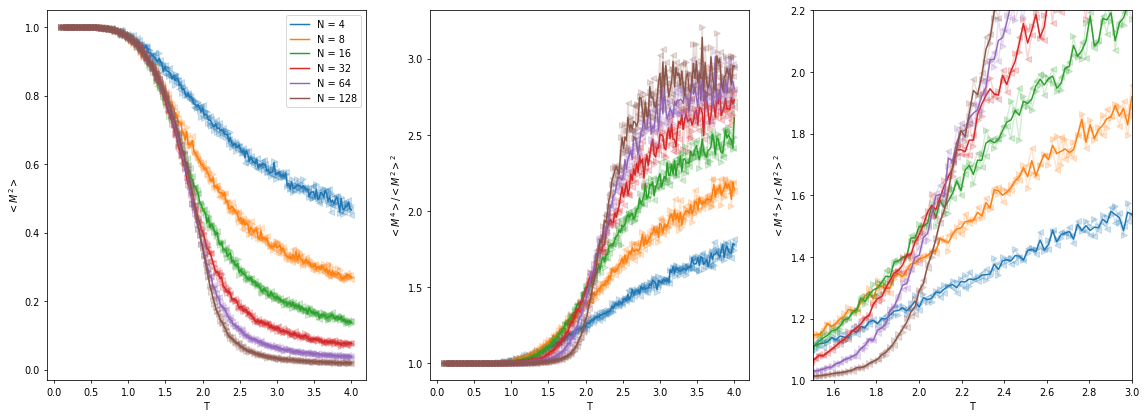

In [16]:
f, axes = plot_m(oLR)
f.savefig('./LR_binder_plots.pdf')

In [11]:
with open('/data/users/tch14/pickled_data/Short_range_linear_T.pickle', 'rb') as file: 
    oSR = pickle.load(file)

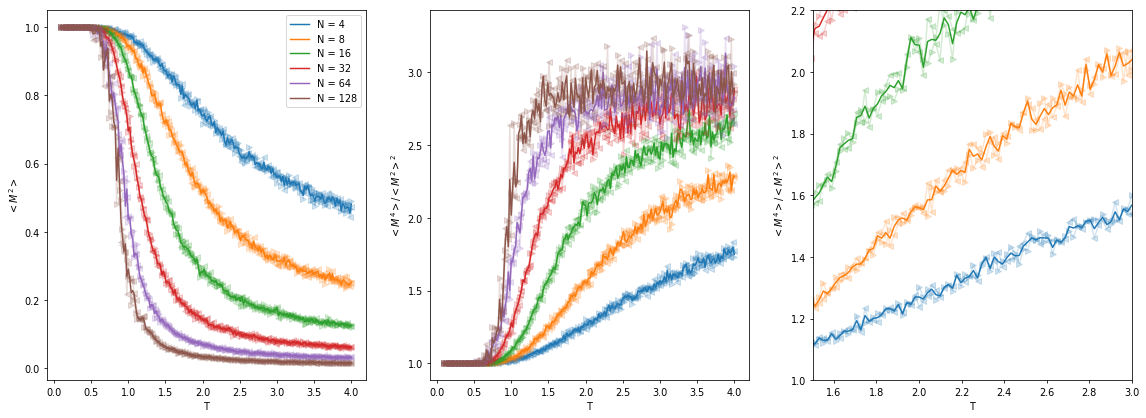

In [17]:
f, axes = plot_m(oSR)
f.savefig('./SR_binder_plots.pdf')

In [24]:
def plot_IPR(oall, save_in_file = None):
    f, axes = plt.subplots(2,1, figsize = (10,10), sharex = 'all', sharey = 'all')

    o = oall
    N = o.Ns[-1]

    #can only concatenate one run because the shape depends on the system size
    E_vals = oall.E_vals
    IPRs = oall.IPRs

    #use this to select specific initial states if necessary 
    state_select = (0,1,2,3)
    E_vals = E_vals[:, :, state_select, :, :]
    IPRS = IPRs[:, :, state_select, :, :]

    newshape = E_vals.shape[0:1] + (-1,)
    IPRs = IPRs.reshape(*newshape)
    E_vals = E_vals.reshape(*newshape)

    shapes(IPRs=IPRs, E_vals = E_vals)

    E_bins = np.linspace(-6, 6, 2000 + 1)
    E_hist, _, indices = index_histogram_array(E_bins, E_vals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)

    shapes(E_bins=E_bins, E_hist=E_hist, IPR_hist=IPR_hist)

    I = np.where(E_hist > 0, IPR_hist/E_hist, 0)

    sI = smooth(I, scale = 1, axis = -1)
    sE = smooth(E_hist, scale = 1, axis = -1)

    norm = colors.Normalize(vmin = 0)
    cs = axes[0].pcolormesh(E_bins, o.Ts, sE, cmap='RdBu_r', norm = norm)

    norm = colors.Normalize(vmin = 0)
    cs = axes[1].pcolormesh(E_bins, o.Ts, sI, cmap='RdBu_r', norm = norm)
    
    if save_in_file != None:
        np.savez(save_in_file, E_bins = E_bins, Ts = o.Ts, E_hist = E_hist, I = I)
        with open(save_in_file, 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            if 'MCMC_parameters' in oall.keys(): oall.MCMC_params = oall.MCMC_parameters
            
            data = Munch(
                         parameters = oall.parameters,
                         MCMC_params = oall.MCMC_params,
                         E_bins = E_bins,
                         Ts = o.Ts,
                         E_hist = E_hist,
                         I = I)
            
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

            print('Pickling Successful')
        

    

#f.colorbar(cs)

'''
#save for plotting elsewhere
data = dict(
    command = 'sI = smooth(I, scale = 1, axis = -1); cs = ax[0].pcolormesh(E_bins, o.Ts, sE, cmap="RdBu_r", norm = norm)',
    N = N,
    E = E_hist,
    I = I,
    E_bins = E_bins,
    T = o.Ts,
)
file = '/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs/SR_gap_opening.npz'
np.savez(file, **data)
''';

IPRs.shape = (200, 512000), E_vals.shape = (200, 512000)
E_bins.shape = (2001,), E_hist.shape = (200, 2000), IPR_hist.shape = (200, 2000)


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Pickling Successful


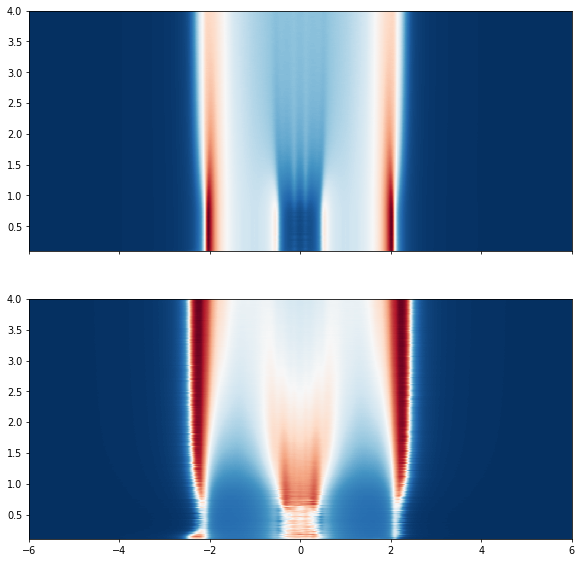

In [25]:
plot_IPR(oSR, save_in_file = './Short_range_IPR_and_DOS.pickle')

IPRs.shape = (200, 512000), E_vals.shape = (200, 512000)
E_bins.shape = (2001,), E_hist.shape = (200, 2000), IPR_hist.shape = (200, 2000)


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Pickling Successful


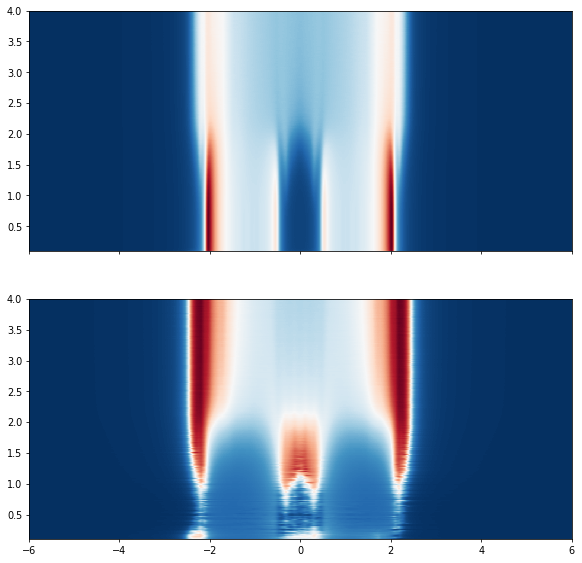

In [26]:
plot_IPR(oLR, save_in_file = './Long_range_IPR_and_DOS.pickle')